<h1>Dogs vs Cats classifier using Transfer Learning</h1>

In [1]:
import os, cv2, random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 
import keras
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16
from keras.models import Model
import warnings
warnings.filterwarnings('ignore')

<h2>Loading and process images</h2>

  1%|▌                                                                              | 54/8000 [00:00<00:14, 535.93it/s]

['cat.6399.jpg', 'cat.64.jpg', 'cat.640.jpg', 'cat.6400.jpg', 'cat.6401.jpg']


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 532.94it/s]


Train shape: (8000, 224, 224, 3)
Test shape: (200, 224, 224, 3)


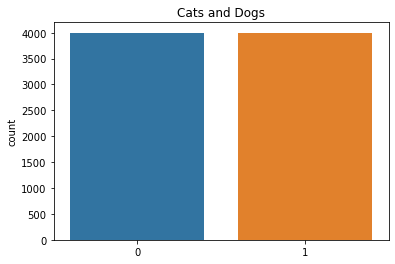

In [3]:
# variables for model
ROWS = 224
COLS = 224
CHANNELS = 3
BATCH_SIZE = 16
STEPS_PER_EPOCH = 200
EPOCHS = 3

# directory containing all train images, the images are stored with names
# images of dogs are stored as dog.xx.jpg where xx is a number
# similarly for cats
# we use this to geenrate train data of cats and dogs 
# also to generate train labels
TRAIN_DIR = os.path.join(os.getcwd(),'images')

# test_images dir contains images with no lables
# we use it for checking our model
TEST_DIR = os.path.join(os.getcwd(),'test_images')

print(os.listdir(TRAIN_DIR)[:5])
train_dogs = [os.path.join(TRAIN_DIR, i) for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats = [os.path.join(TRAIN_DIR, i) for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images = [os.path.join(TEST_DIR, i) for i in os.listdir(TEST_DIR)[0:200]]

train_images = train_dogs + train_cats

# shuffling data
random.shuffle(train_images)

# function to read image file and resize to 224 x 224
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) 
    if img is None:
        print("Wrong path: ", file_path)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

# convert list of images to numpy array
def process_images(images):
    data = []
    for i in tqdm(images):
        image = read_image(i)
        data.append(image)
    return np.array(data)

train = process_images(train_images)
test = process_images(test_images)

labels = []
for i in train_images:
    if 'dog' in i.split('/')[-1]:
        labels.append(1)
    else:
        labels.append(0)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

sns.countplot(labels).set_title('Cats and Dogs')
labels = np.array(labels)

<h2>Some images from dataset</h2>

(224, 224, 3)


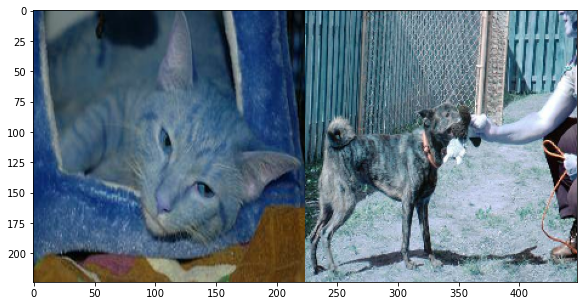

(224, 224, 3)


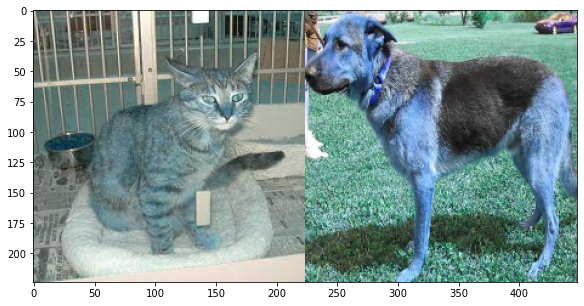

(224, 224, 3)


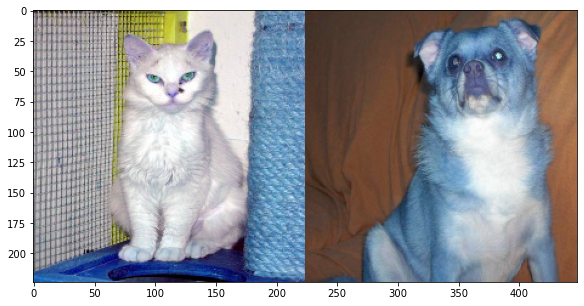

(224, 224, 3)


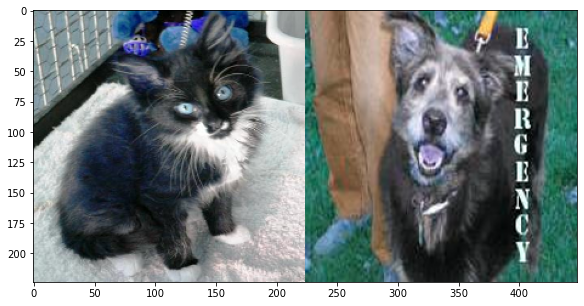

(224, 224, 3)


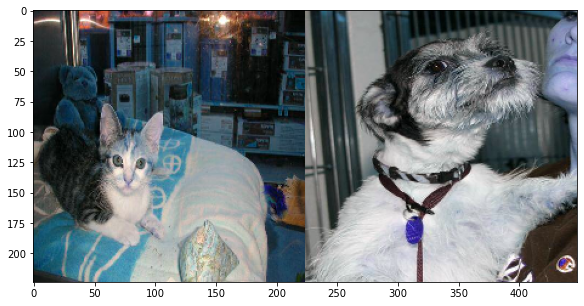

In [4]:
def show_images(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    print(cat.shape) 
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()

for i in np.random.randint(0, 4000, 5):
    show_images(i)

<h2>Creating model</h2>

In [5]:
vgg16 = VGG16(include_top = False, # drop top layers
              weights = 'imagenet', # weights used in training imagenet
              input_shape=(ROWS, COLS, 3))

vgg16.trainable = False # freezing the base model

In [6]:
inputs = keras.Input(shape=(ROWS, COLS, 3)) # defining the input layer

outputs = vgg16(inputs, training=False)
outputs = Flatten()(outputs)
outputs = Dense(1, activation ='sigmoid')(outputs)
model = Model(inputs=inputs, outputs = outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
model.compile(optimizer ='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

<h2>Training Model</h2>

In [8]:
model.fit(train, labels, batch_size=BATCH_SIZE, epochs=EPOCHS,
              validation_split=0.2, verbose=1, shuffle=False)
model.save('trained_model', overwrite=True, save_format='h5')

Epoch 1/3
400/400 [==============================] - 67s 153ms/step - loss: 1.4506 - accuracy: 0.9527 - val_loss: 1.5389 - val_accuracy: 0.9569
Epoch 2/3
400/400 [==============================] - 62s 154ms/step - loss: 0.5319 - accuracy: 0.9839 - val_loss: 4.3831 - val_accuracy: 0.9206
Epoch 3/3
400/400 [==============================] - 62s 155ms/step - loss: 0.3123 - accuracy: 0.9906 - val_loss: 1.5356 - val_accuracy: 0.9750


<h2>Testing on test random test images</h2>

In [9]:
predictions = model.predict(test, verbose=1)

7/7 [==============================] - 10s 653ms/step


I am 100.00% sure this is a Cat


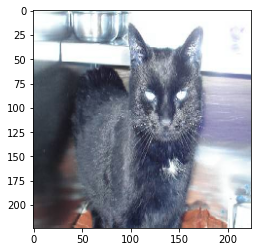

I am 100.00% sure this is a Dog


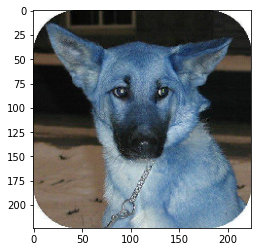

I am 100.00% sure this is a Cat


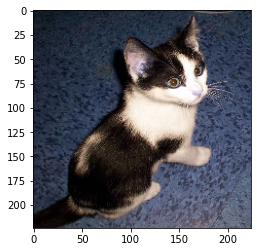

I am 100.00% sure this is a Cat


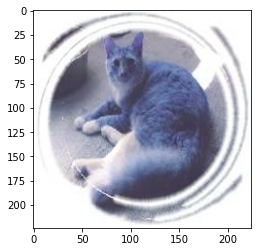

I am 100.00% sure this is a Cat


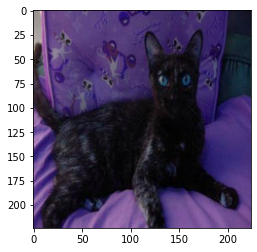

I am 100.00% sure this is a Cat


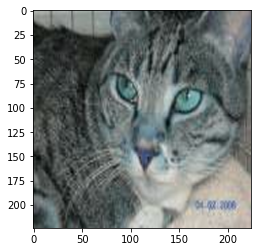

I am 100.00% sure this is a Cat


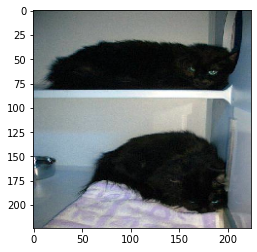

I am 100.00% sure this is a Dog


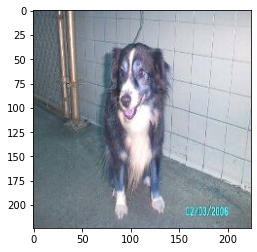

I am 100.00% sure this is a Cat


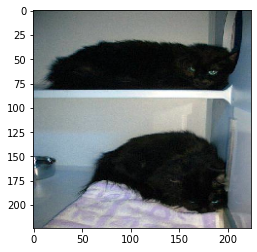

I am 100.00% sure this is a Cat


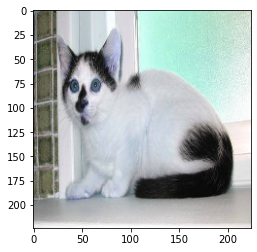

I am 100.00% sure this is a Dog


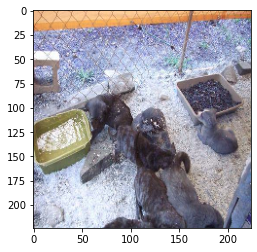

I am 100.00% sure this is a Cat


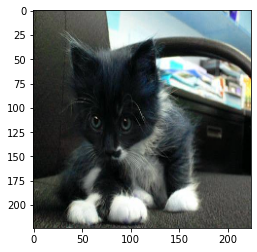

I am 100.00% sure this is a Cat


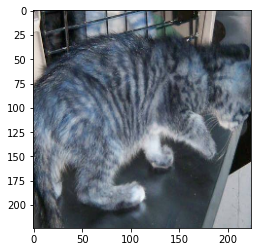

I am 100.00% sure this is a Dog


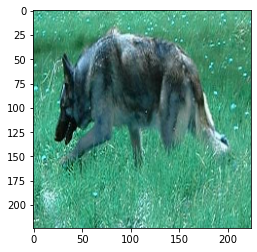

I am 100.00% sure this is a Cat


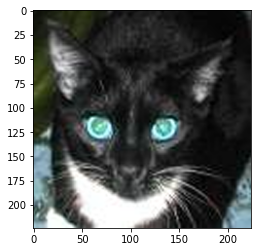

I am 100.00% sure this is a Cat


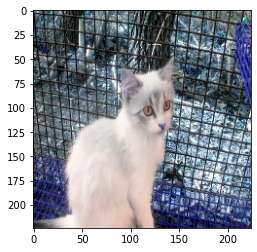

I am 100.00% sure this is a Dog


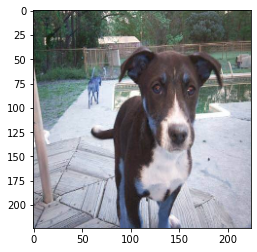

I am 100.00% sure this is a Cat


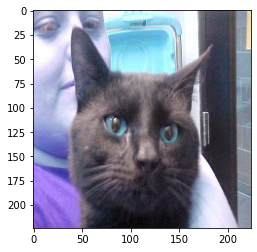

I am 100.00% sure this is a Cat


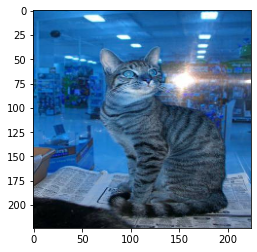

I am 100.00% sure this is a Dog


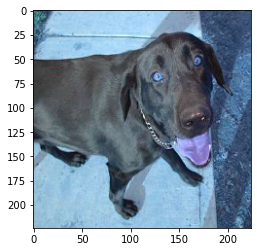

In [11]:
for i in np.random.randint(0, 200, 20):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
    plt.imshow(test[i])
    plt.show()